In [178]:
import numpy as np
import math
import sklearn.decomposition as sk
import seaborn as sns
sns.set_style("whitegrid")
sns.reset_orig()
import warnings
warnings.filterwarnings('ignore')
from scipy.special import gammainc
from scipy.special import lambertw
from matplotlib import pyplot as plt
import scipy.io


def histc(X, bins):

    map_to_bins = np.digitize(X,bins)
    r = np.zeros((len(X[0,:]),len(bins)))
    for j in range(len(map_to_bins[0,:])):
        for i in map_to_bins[:,j]:
            r[j,i-1] += 1
    return [r, map_to_bins]

def randsphere(n_points,ndim,radius):
    center = np.array([0]*ndim)
    r = radius
    x = np.random.normal(size=(n_points, ndim))
    ssq = np.sum(x**2,axis=1)
    fr = r*gammainc(ndim/2,ssq/2)**(1/ndim)/np.sqrt(ssq)
    frtiled = np.tile(fr.reshape(n_points,1),(1,ndim))
    p = center + np.multiply(x,frtiled)
    return p, center

def preprocessing(X,center,dimred,whiten,projectonsphere,eigval_retaining_factor = 10):
    Xp = X
    #centering
    nobjects = len(X[:,0])
    sampleMean = np.mean(X,axis=0)
    if center:
        Xp = X-sampleMean
    #dimension reduction
    PCAcomputed = 0
    if dimred or whiten:
        pca = sk.PCA()
        u = pca.fit_transform(Xp)
        v = pca.components_.T
        s = pca.explained_variance_
        PCAcomputed = 1
        sc = s/s[0]
        ind = np.where(sc > 1/eigval_retaining_factor)[0]
        Xp = Xp@v[:,ind]
        print('%i components are retained using factor %2.2f' %(len(ind),eigval_retaining_factor))
    #whitening
    if whiten:
        Xp = u[:,ind]
        st = np.std(Xp,ddof=1)
        Xp = Xp/np.tile(st,(nobjects,1))
    #project on sphere (scale each vector to unit length)
    if projectonsphere:
        st = np.sqrt(np.sum(Xp**2,axis=1))
        st = np.array([st]).T
        Xp = Xp/(np.tile(st,(1,len(Xp[0,:]))))
    
    return Xp        

def probability_unseparable_sphere(alpha,n):
    p = np.power((1-alpha*alpha),(n-1)/2)/(alpha*np.sqrt(2*math.pi*n))
    return p

def checkSeparability(xy,alpha):
    dxy = np.diag(xy)
    sm = (xy/dxy).T
    sm = sm - np.diag(np.diag(sm))
    sm = sm>alpha
    py = sum(sm.T)
    py = py/len(py[0,:])
    separ_fraction = sum(py==0)/len(py[0,:])
    
    return separ_fraction,py

def checkSeparabilityMultipleAlpha(xy,alpha):

    dxy = np.diag(xy)
    sm = (xy/dxy).T


    if len(alpha[:,0])>1:
        alpha = alpha.T
    addedone = 0
    if max(alpha[0,:])<1:
        alpha = np.array([np.append(alpha,1)])
        addedone = 1

    alpha = np.concatenate([[float('-inf')],alpha[0,:], [float('inf')]])

    sm = sm - np.diag(np.diag(sm))
    
#     sm = scipy.io.loadmat('sm.mat')['sm']

    [counts,binMap] = histc(sm.T,alpha)
    
    na=len(alpha)
    
    for i in range(na-1): 
        counts[:,na-i-2]=counts[:,na-i-2]+counts[:,na-i-1]
    
    py = counts/len(sm[:,0])
    py = py.T
    if addedone:
        py = py[1:-2,:]
    else:
        py = py[1:-1,:]
    
    separ_fraction = sum(py==0)/len(py[0,:])
    
    return separ_fraction,py

def dimension_uniform_sphere(py,alpha,number_of_data_points):

    if len(py)!=len(alpha[0,:]):
        print('ERROR: length of py (%i) and alpha (%i) does not match'%(len(py),len(alpha[0,:])))
        return
    
    n = np.zeros((len(alpha[0,:])))
    for i in range(len(alpha[0,:])):
        if alpha[0,i]>=1:
            print('ERROR: alpha is >=1')
            return 
        if alpha[0,i]<=0:   
            print('ERROR: alpha is <=0')
            return
        else:
            p  = py[i]
            a  = alpha[0,i]
            a2 = alpha[0,i]**2
            n[i] = lambertw(-(np.log(1-a2)/(2*math.pi*p*p*a*a*(1-a2))))/(-np.log(1-a2))
 
    n[n==np.inf]= float('nan')
    inds = np.where(~np.isnan(n))[0]
    alpha_max = max(alpha[0,inds])
    alpha_ref = alpha_max*0.9
    k = np.where(abs(alpha[0,inds]-alpha_ref)==min(abs(alpha[0,:]-alpha_ref)))[0]
    alfa_single_estimate = alpha[0,inds[k]]
    p = py[inds[k]]
    a = alfa_single_estimate
    a2 = alfa_single_estimate**2 
    n_single_estimate = lambertw(-(np.log(1-a2)/(2*math.pi*p*p*a*a*(1-a2))))/(-np.log(1-a2))
    
    return n,n_single_estimate,alfa_single_estimate

def SeparabilityAnalysis(X,ColinearityControl=10,ProjectOnSphere = 1,alphas = np.array([np.arange(.6,1,.02)]),ProducePlots = 1):
    
    Xp = preprocessing(X,1,1,1,ProjectOnSphere,eigval_retaining_factor=ColinearityControl)
    xy = Xp@Xp.T
    npoints = len(X[:,0])
#     xy = scipy.io.loadmat('xy.mat')['xy']
    [separable_fraction,p_alpha] = checkSeparabilityMultipleAlpha(xy,alphas)
    py_mean = np.mean(p_alpha,axis=1)
    
    [n_alpha,n_single,alpha_single] = dimension_uniform_sphere(py_mean,alphas,npoints)

    alpha_ind_selected = np.where(n_single==n_alpha)[0]
    
    if ProducePlots:
        
        n_min = np.floor(min(n_alpha));
        n_max = np.floor(max(n_alpha)+0.8);
        if n_min==0:
            n_min = 1
        if n_min>1:
            n_min = n_min-1
        if n_min>1:
            n_min = n_min-1

        n_max = n_max+2
        ns = np.arange(n_min,n_max)
        
        plt.figure()
        plt.plot(alphas[0,:],n_alpha,'ko-');plt.plot(alphas[0,alpha_ind_selected],n_single,'rx',markersize=16)
        plt.xlabel('Alpha'); plt.ylabel('Effective dimension') ; plt.show()
        nbins = int(round(np.floor(npoints/200)))

        if nbins<20:
            nbins = 20
        

        plt.figure()
        plt.hist(p_alpha[alpha_ind_selected,:][0],bins=nbins)
        plt.xlabel('unseparability prob.p for alpha=%2.2f'%(alphas[0,alpha_ind_selected])); plt.ylabel('Number of values');plt.show()

        plt.figure()
        plt.semilogy(alphas[0,:],py_mean,'bo-','LineWidth',3);
        plt.xlabel('Alpha'); plt.ylabel('Mean unseparability prob.');
        plt.title('Theor.curves for n=%i:%i'%(n_min,n_max))

        pteor = np.zeros((len(ns),len(alphas[0,:])))
        for k in range(len(ns)):
            for j in range(len(alphas[0,:])):
                pteor[k,j] = probability_unseparable_sphere(alphas[0,j],ns[k])

        for i in range(len(pteor[:,0])):
            plt.semilogy(alphas[0,:],pteor[i,:],'-',color='r')
        plt.xlim(min(alphas[0,:]),1); plt.show()


    return n_alpha,n_single,p_alpha,alphas,separable_fraction

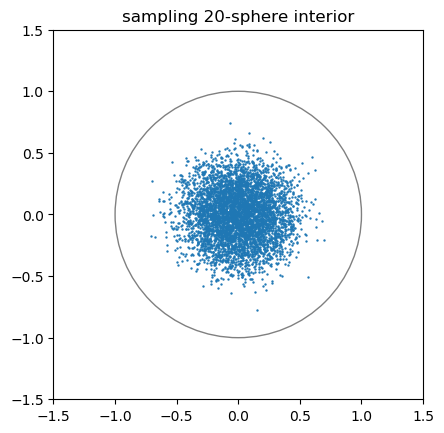

20 components are retained using factor 10.00


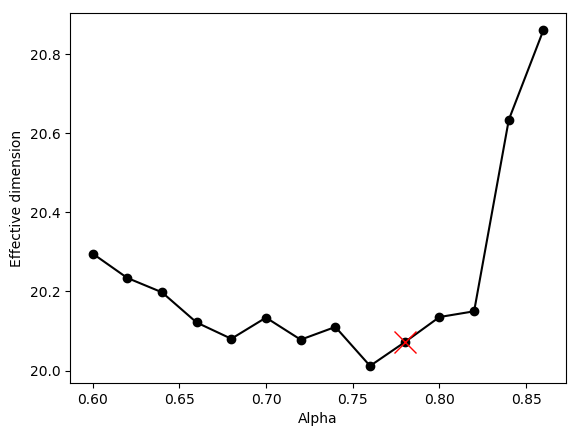

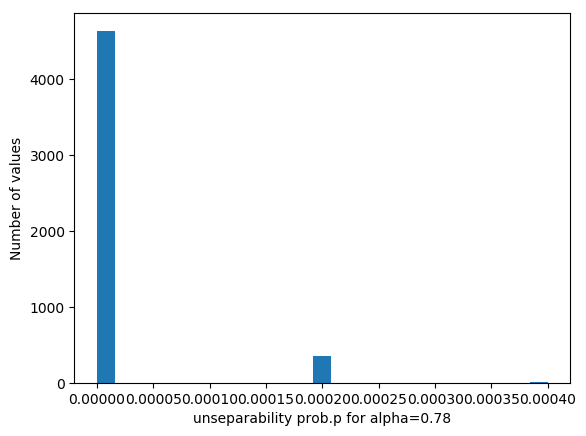

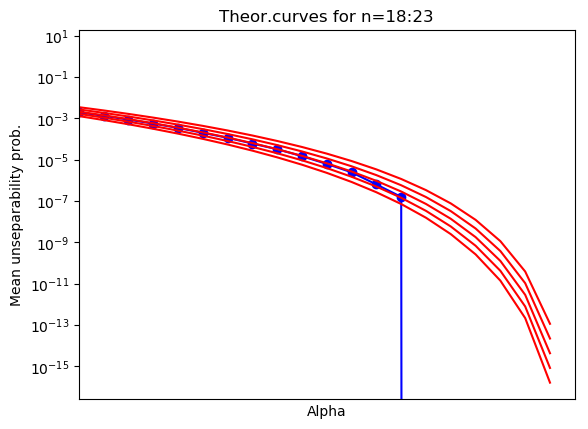

In [180]:
fig1 = plt.figure()
ax1 = fig1.gca()
npoints = 5000
dimension = 20
radius = 1
X,center = randsphere(npoints,dimension,radius)
ax1.scatter(X[:,0],X[:,1],s=0.5)
ax1.add_artist(plt.Circle(center,radius,fill=False,color='0.5'))
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(-1.5,1.5)
ax1.set_aspect('equal')
ax1.set_title('sampling %i-sphere interior'%dimension)
plt.show()

[n_alpha,n_single,p_alpha,alphas,separable_fraction] = SeparabilityAnalysis(X)